In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import numpy as np
import nengo_dft
import cedar_modules

In [2]:
class AbsSigmoid(nengo.neurons.NeuronType):
    def __init__(self, initial_state=None):
        super().__init__(initial_state)

    def step(self, dt, J, output):
        output[...] = 0.5 * (1 + (J) / (1 + np.abs(J)))

In [46]:
dt = 0.02
step_size = 0.02

model = nengo.Network()
with model:
    gauss_input = cedar_modules.GaussInput(sizes=[100], centers=[24], a=1, sigmas=[3], normalize=False).make_node()
    gauss_input_2 = cedar_modules.GaussInput(sizes=[80], centers=[31], a=1, sigmas=[12], normalize=False).make_node()
    
    neural_field = nengo_dft.DFT(shape=[100], h=-1, c_noise=0.1, beta=100, global_inh=0.01, dt=dt, 
                                 tau=(100)*step_size, neuron_type=AbsSigmoid())
    neural_field.add_single_kernel(amplitude=1, sigma=3.0, limit=5)

    neural_field_2 = nengo_dft.DFT(shape=[50, 40], h=-5, c_noise=0.1, beta=100, global_inh=0.01, dt=dt, 
                                 tau=(100)*step_size, neuron_type=AbsSigmoid())
    neural_field_2.add_single_kernel(amplitude=1, sigma=3, limit=5)    
    
    neural_field_3 = nengo_dft.DFT(shape=[80], h=-1, c_noise=0.1, beta=100, global_inh=0.01, dt=dt, 
                                 tau=(100)*step_size, neuron_type=AbsSigmoid())
    neural_field_3.add_single_kernel(amplitude=1, sigma=3, limit=5)
    
    
    convolution = cedar_modules.Convolution(input_shape=[100], amplitude=1, sigma=3, limit=5)
    convolution_2 = cedar_modules.Convolution(input_shape=[80], amplitude=1, sigma=3, limit=5)
    
    projection = cedar_modules.Projection([50, 40], [100], dimension_mapping={0:0}).make_node()
    projection_2 = cedar_modules.Projection([50, 40], [80], dimension_mapping={0:1}).make_node()
    

    nengo.Connection(gauss_input, neural_field.s, synapse=None)
    nengo.Connection(gauss_input_2, neural_field_3.s, synapse=None) 
    
    nengo.Connection(neural_field.g.neurons, convolution.input, synapse=None)
    nengo.Connection(neural_field_3.g.neurons, convolution_2.input, synapse=None)
    
    nengo.Connection(convolution.output, projection, synapse=None)
    nengo.Connection(convolution_2.output, projection_2, synapse=None)
    
    nengo.Connection(projection, neural_field_2.s, synapse=None)
    nengo.Connection(projection_2, neural_field_2.s, synapse=None)
    
    boost = nengo.Node(4.4)
    nengo.Connection(boost, neural_field_2.s, synapse=None, transform=np.ones((neural_field_2.s.size_in, 1)))
    
    p_dnf = nengo.Probe(neural_field.g.neurons)
    p_dnf_2 = nengo.Probe(neural_field_2.g.neurons)#, attr='input')
    p_dnf_3 = nengo.Probe(neural_field_3.g.neurons)
    
    p_conv = nengo.Probe(convolution.output)
    p_conv_2 = nengo.Probe(convolution_2.output)
    
    p_projection = nengo.Probe(projection)
    p_projection_2 = nengo.Probe(projection_2)
    
    
sim = nengo.Simulator(model, dt=dt)
with sim:
    sim.run(10)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

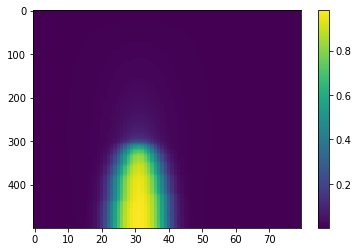

In [47]:
plt.imshow(sim.data[p_conv_2], aspect='auto', interpolation='nearest')
plt.colorbar()

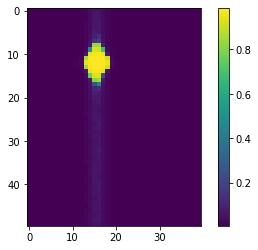

In [48]:
plt.imshow(sim.data[p_dnf_2][-1].reshape(50,40))
plt.colorbar()

In [49]:
import nengo_gui.jupyter
nengo_gui.jupyter.InlineGUI(model)